# **Jacob Shearer - Final Project**

In [1]:
import random
import numpy as np
import scipy.fft as fft
import scipy.stats as stats
import matplotlib.pyplot as plt

In [58]:
def test_signal(n_sample_points, sample_spacing):
    sampling_times = np.linspace(0.0, n_sample_points*sample_spacing, n_sample_points)
    A = 1
#     analog_signal = lambda t: A*np.e**(-(1/2)*(np.log(t/7)/0.45)**2)
    analog_signal = lambda t:A*(np.sin(4*t) + np.sin(5*t) + np.sin(6*t))
    digital_signal = analog_signal(sampling_times)
    return sampling_times, digital_signal

In [23]:
def ft(n_sample_points, sample_spacing, times, signal):
    frequencies = fft.fftfreq(n_sample_points, sample_spacing)
    signal_fft = fft.fft(signal)
    return frequencies, signal_fft

In [19]:
def ift(signal_fft):
    signal = np.real(fft.ifft(signal_fft))
    return signal

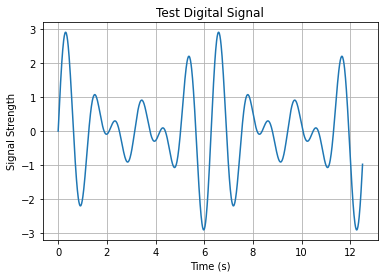

In [93]:
n_sample_points = 1000
sample_spacing = 1/80
times, signal = test_signal(n_sample_points, sample_spacing)
plt.plot(times, signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Test Digital Signal')
plt.grid()
plt.show()

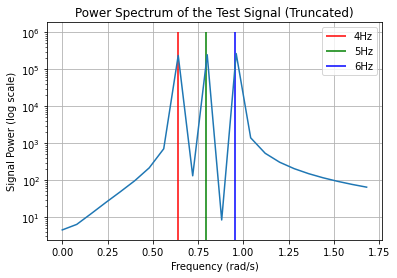

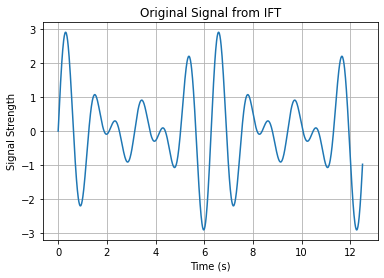

In [103]:
frequencies, signal_fft = ft(n_sample_points, sample_spacing, times, signal)
power_spectrum = np.abs(signal_fft)**2
plt.plot(frequencies[:int(len(frequencies)/45)], power_spectrum[:int(len(frequencies)/45)])
plt.vlines([4/(2*np.pi)], 0, 10**6, colors=('r'), label='4Hz')
plt.vlines([5/(2*np.pi)], 0, 10**6, colors=('g'), label='5Hz')
plt.vlines([6/(2*np.pi)], 0, 10**6, colors=('b'), label='6Hz')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Signal Power (log scale)')
plt.yscale('log')
plt.legend()
plt.title('Power Spectrum of the Test Signal (Truncated)')
plt.grid()
plt.show()

original_signal = ift(signal_fft)
plt.plot(times, original_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Original Signal from IFT')
plt.grid()
plt.show()

In [95]:
def add_noise(signal, noise_amplitude, seed_n=None):
    if seed_n is not None:
        np.random.seed(seed_n)
    
    noise_function = lambda:noise_amplitude*np.random.normal(0, 1)
    noisy_signal = np.zeros(len(signal))
    for i in range(len(signal)):
        noisy_signal[i] = signal[i] + noise_function()
    
    return noisy_signal

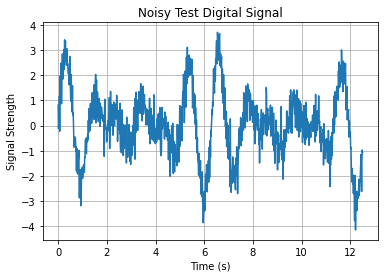

In [98]:
n_sample_points = 1000
sample_spacing = 1/80
times, signal = test_signal(n_sample_points, sample_spacing)
seed_n = 1
noise_amplitude = 0.5
noisy_signal = add_noise(signal, noise_amplitude, seed_n)
plt.plot(times, noisy_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Noisy Test Digital Signal')
plt.grid()
plt.show()

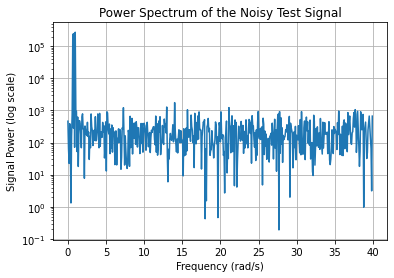

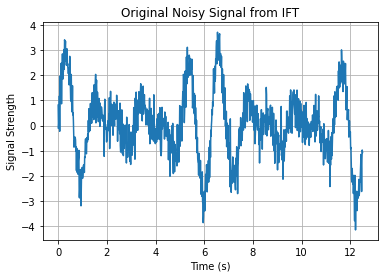

In [99]:
frequencies, noisy_signal_fft = ft(n_sample_points, sample_spacing, times, noisy_signal)
noisy_power_spectrum = np.abs(noisy_signal_fft)**2
plt.plot(frequencies[:int(len(frequencies)/2)], noisy_power_spectrum[:int(len(frequencies)/2)])
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Signal Power (log scale)')
plt.yscale('log')
plt.title('Power Spectrum of the Noisy Test Signal')
plt.grid()
plt.show()

original_noisy_signal = ift(noisy_signal_fft)
plt.plot(times, original_noisy_signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
plt.title('Original Noisy Signal from IFT')
plt.grid()
plt.show()